In [1]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import matplotlib.pylab as plt

In [2]:
sys.path.append("/hetghome/antonpr/xmax_sigma/flincpy")
from cascade.cascade_driver import CascadeDriver, InteractionModel

In [3]:
import chromo
target = chromo.kinematics.CompositeTarget([("N", 0.78), ("O", 0.22)])
ekin = chromo.kinematics.FixedTarget(1e7, "O16", target)
model = chromo.models.DpmjetIII191
    
int_model0 = InteractionModel(model, ekin, target)

In [4]:
cas_driver = CascadeDriver(int_model0)

In [5]:
mceq_decaying_pdgs = [-11, 11, -12, 12, -13, 13, -14, 14, 
                      -16, 16, 22, -211, 211,
                        111, 130, 310, -321, 321, 
                        -411, 411, -421, 421, -431, 431, 
                        -2112, 2112, -2212, 2212, -3122, 3122
                        ]


cas_driver.simulation_parameters(pdg = 2212, energy = 1e3, 
                                 zenith_angle = 30, xdepth = 0,
                                 threshold_energy = 1e2, stop_height = 0,
                                 accumulate_runs = True, reset_ids = True,
                                 mceq_decaying_pdgs = mceq_decaying_pdgs)


stop depth = 1195.9290875457918


In [7]:
cas_driver.run(1)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:13<00:00, 13.63s/it]


In [67]:
from cascade.cascade_analysis import CascadeAnalysis
cascade_analysis = CascadeAnalysis(cas_driver)
cascade_analysis.print_stats()

Initial state:
  $p$(2212) with energy = 1.000e+03

Final state:
  Number of all particles in cascade = 90
  Number of final particles = 83
  Number of interactions = 5
  Number of decays = 4
  Max number of generations = 5

  Max xdepth = 1195.9290875457918
  Exectution time = 0.03 s
  Size of cascade_driver object = 5.18 Mb

Energy conservation in cascade:
  Initial energy = 1.00000e+03 GeV
  Energy in final particles = 1.00459e+03 GeV
  Relative loss(+)/gain(-) -4.592e-03
Final ids = [0] have counts
 [2] with pdgs

Particle with id = 0 with pdgs = [3122 -211] meets 2 times


In [29]:
from MCEq.core import MCEqRun
import mceq_config as config
import crflux.models as pm
# config.mceq_db_fname = "/hetghome/antonpr/MCEq/MCEq/data/mceq_db_lext_dpm191_v150.h5"

mceq_run = MCEqRun(
            #provide the string of the interaction model
            interaction_model="DPMJET-III-19.1",
            #primary cosmic ray flux model
            primary_model = (pm.HillasGaisser2012, "H3a"),
            # Zenith angle in degrees. 0=vertical, 90=horizontal
            theta_deg=30,
            density_model = ("CORSIKA", ("USStd", None))
        )

MCEqRun::set_interaction_model(): DPMJETIII191


ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


In [30]:
sys.path.append("/hetghome/antonpr/xmax_sigma/flincpy")
from histograms.grid_collector import MceqGridCollector
from histograms.mceq_solve_rhs import solve_rhs
grid_collector = MceqGridCollector(mceq_run=mceq_run,
                                   int_grid = [600, 800, 900, 1000])

In [72]:
final_particles = cas_driver.get_final_particles().valid()
grid_collector.add_particles(final_particles, 
                         nruns = cas_driver.runs_number)

In [32]:
solve_rhs(mceq_run, int_grid = [600, 800, 900, 1000], 
                     grid_var = "X",
                     rhs_source = grid_collector.state_vectors())

(1673,)
1673


In [76]:
final_particles = cas_driver.get_final_particles().valid()

In [101]:
grid_collector.clear()
grid_collector.add_particles(final_particles)

In [106]:
grid_collector.number_particles_on_grid()

83.00000000000011

In [107]:
grid_collector.tot_energy_on_grid()

1004.5919232975788

In [93]:
np.sum(len(final_particles))/cas_driver.runs_number

83.0

In [94]:
np.sum(final_particles.energy)

1004.5919232975765

In [100]:
np.sum(grid_collector.shower_on_grid()[:, :]*grid_collector.energy_widths)

166.00000000000023

In [105]:
np.sum(grid_collector.shower_on_grid()
       * grid_collector.energy_widths
       * grid_collector.energy_grid)

1004.5919232975788

In [102]:
np.sum(np.sum(grid_collector.shower_on_grid()[:, :] 
       * grid_collector.energy_widths
       * grid_collector.energy_grid, axis=2))

1004.5919232975787

In [48]:
np.sum(np.sum(shower_on_grid[:, :] 
       * grid_collector.energy_widths
       * grid_collector.energy_grid, axis=2))

4750.111543336111

In [45]:
shower_on_grid[400]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [33]:
from mceq_comparison import MCEQDistributions, MCEQExtractDists

In [34]:
mceq_dist = MCEQExtractDists(mceq_run,
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ],
                 slant_depths = [600, 800, 900, 1000]
                 )

In [41]:
mceq_loss = MCEQDistributions(
                 energy = 1e3,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[1e-1, 2e3],
                 slant_depths=[600, 800, 900, 1000],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ],
                 interaction_model = "DPMJET-III-19.1",
                #  interaction_model = "SIBYLL23D",
                 generic_losses_all_charged = True, 
                 enable_energy_loss = True, 
                 muon_helicity_dependence = True,
                 disable_decays = [],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))

MCEqRun::set_interaction_model(): DPMJETIII191


ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


In [35]:
# Plot parameters
params = {"mathtext.default": "regular",
          "text.usetex": False,
          "figure.dpi": 300}          
plt.rcParams.update(params)

Text(0, 0.5, 'Counts/bin/primary')

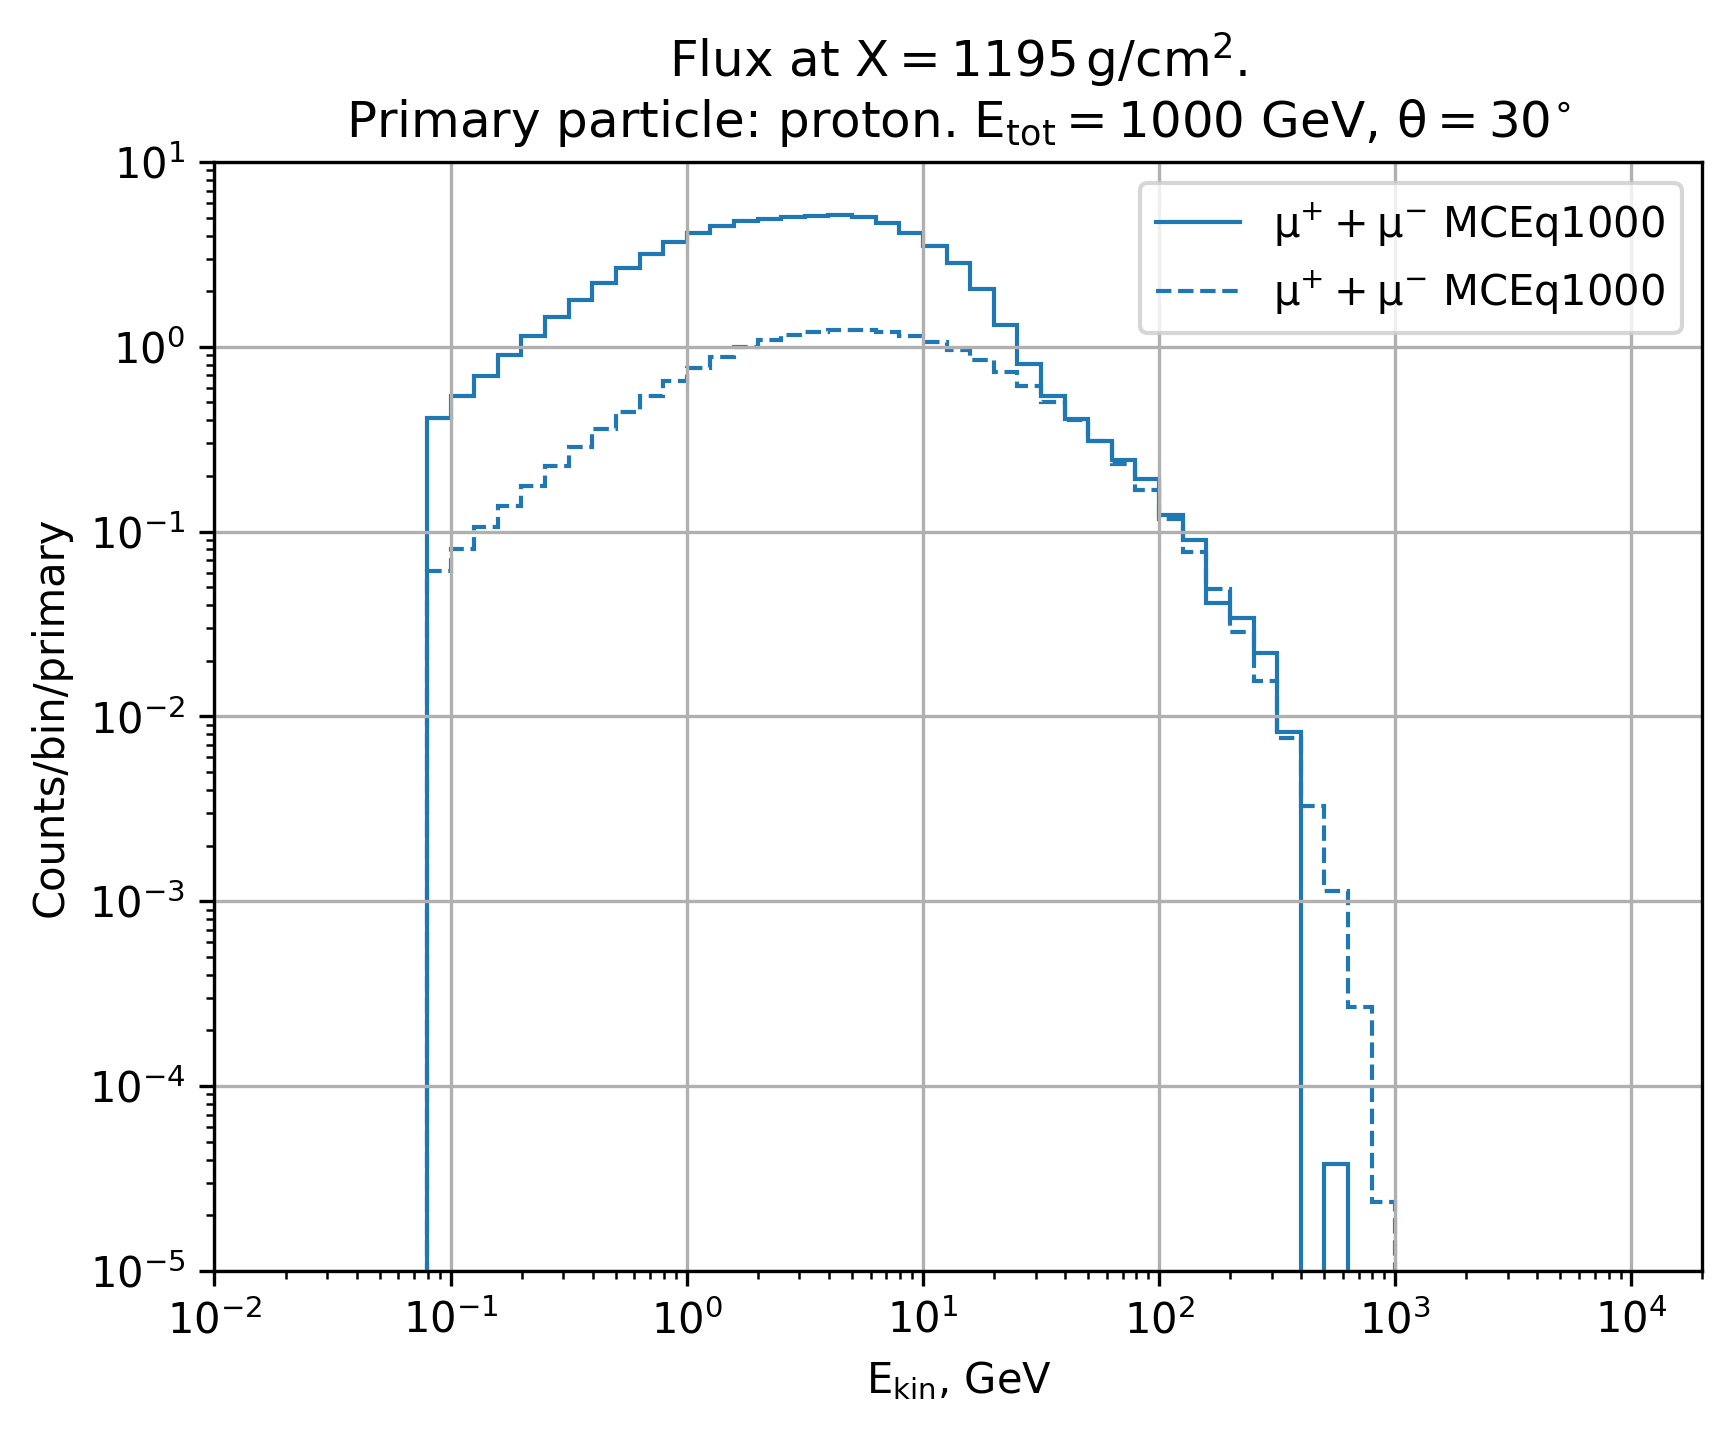

In [42]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-13, 13), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[0])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-12, -12), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[1])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-14, 14), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[2])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211, 211), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11, 11), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"{mceq_dist.slant_depths[ixdepth]}", 
           linestyle='-',
           color = line_colors[0])

plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"{mceq_loss.slant_depths[ixdepth]}", 
           linestyle='--',
           color = line_colors[0])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 2e4)
plt.ylim(1e-5, 10)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=1000$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")
# plt.savefig('01_nomuon_decay_flux.svg')

In [155]:
# Plot parameters
params = {"mathtext.default": "regular",
          "text.usetex": False,
          "figure.dpi": 300}          
plt.rcParams.update(params)

{22: 13336, 2212: 6004, -13: 5775, 14: 5775, 13: 5514, -14: 5514, 11: 2664, -12: 2588, 2112: 951, -11: 164, 12: 88, 111: 73, -2212: 65, 211: 60, -211: 60, 3122: 9, -2112: 2, -3122: 2}


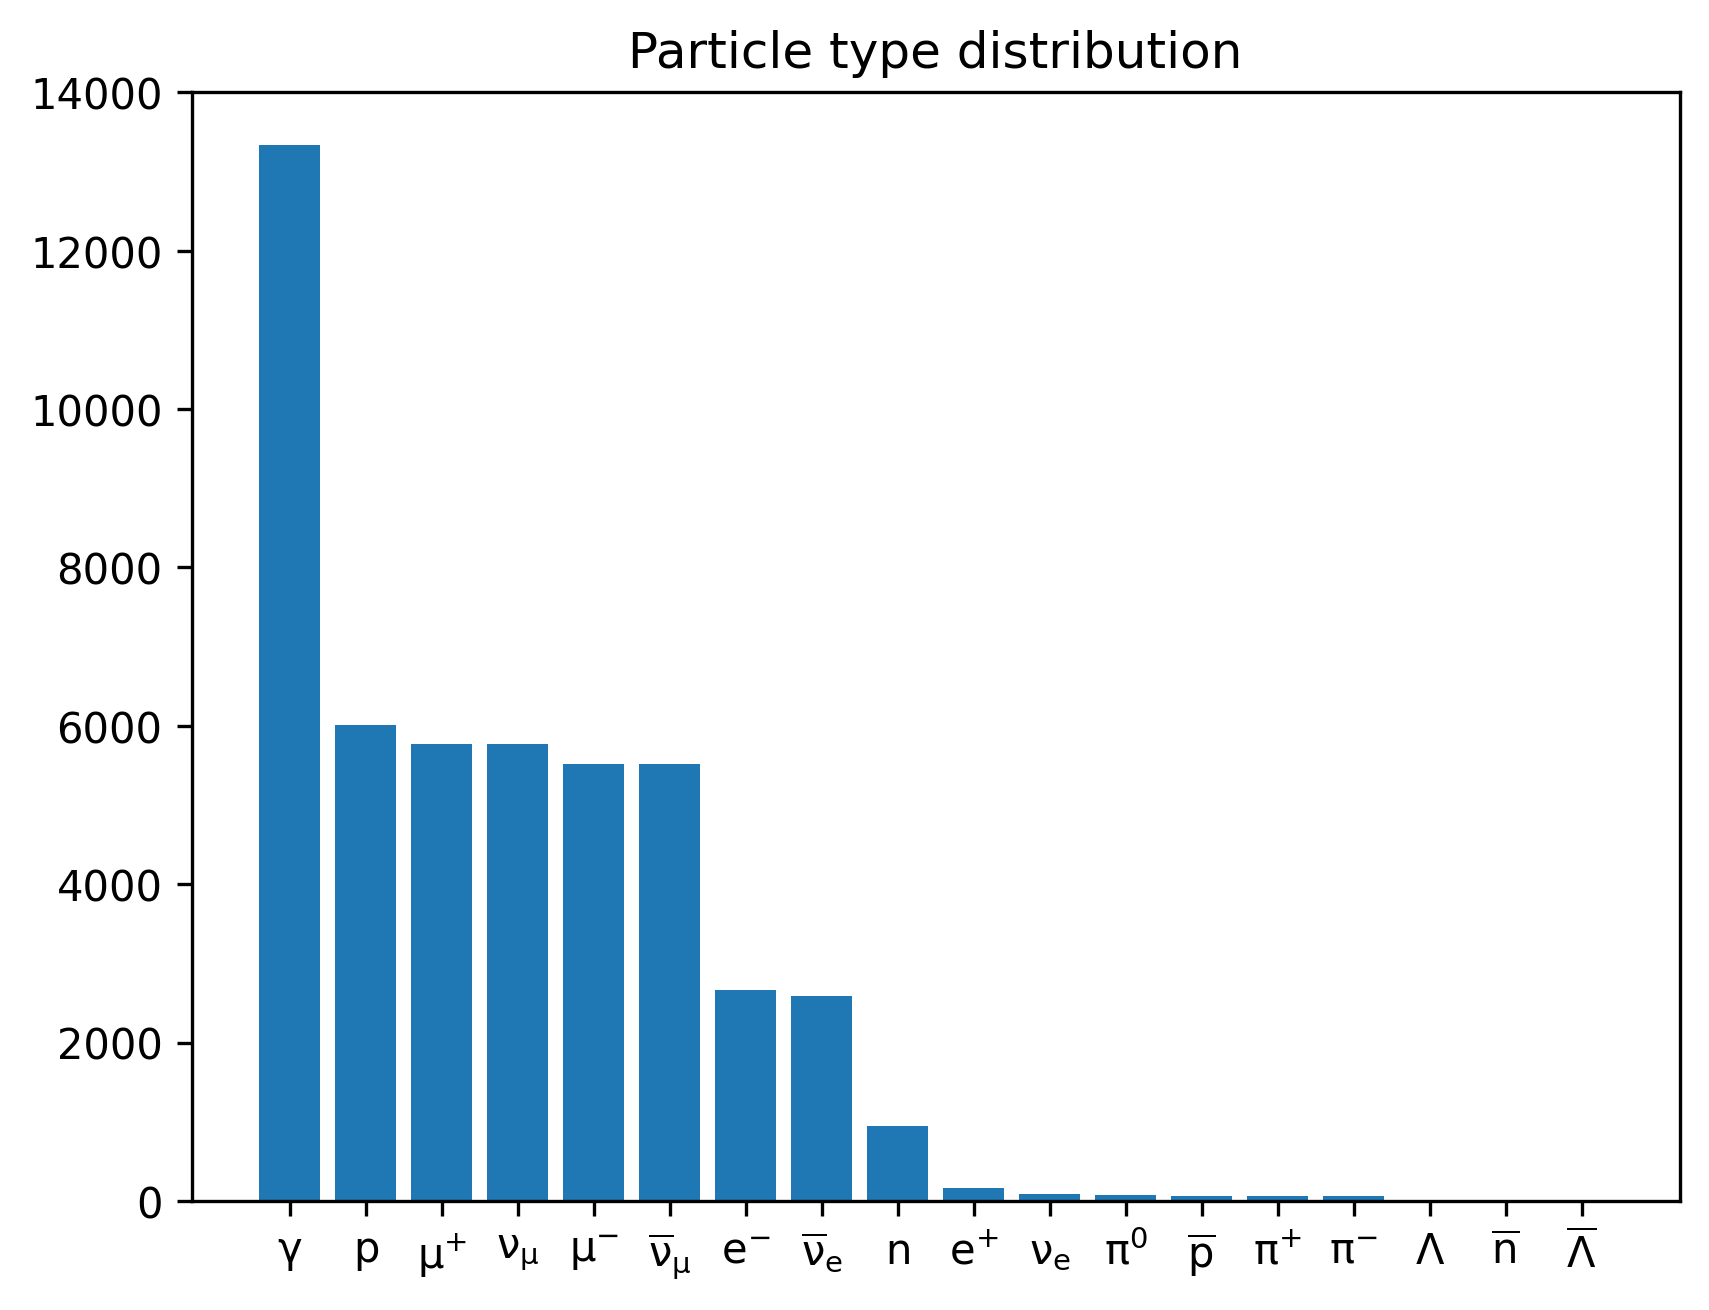

In [233]:
cascade_analysis.plot_ptypes_dist(from_ = 0)

In [ ]:
final_particles = cas_driver.get_final_particles().valid()

In [120]:
from mceq_comparison import MCEQDistributions

In [94]:
mceq_loss = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[3e-2, 2e2],
                 slant_depths=[66, 143, 638, 1193],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ],
                 interaction_model = "DPMJET-III-19.1",
                #  interaction_model = "SIBYLL23D",
                 generic_losses_all_charged = True, 
                 enable_energy_loss = True, 
                 muon_helicity_dependence = True,
                 disable_decays = [],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))

MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


/hetghome/antonpr/MCEq/MCEq/solvers.py:40: RuntimeWarning: overflow encountered in multiply
  phc += (imc.dot(phc) + dmc.dot(ric[step] * phc)) * dxc[step]
/hetghome/antonpr/MCEq/MCEq/solvers.py:40: RuntimeWarning: invalid value encountered in add
  phc += (imc.dot(phc) + dmc.dot(ric[step] * phc)) * dxc[step]


In [258]:
mceq_loss1 = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[5e-2, 2e2],
                 slant_depths=[66, 143, 638, 1193],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-")
                     ],
                 interaction_model = "DPMJET-III-19.1",
                #  interaction_model = "SIBYLL23D",
                 generic_losses_all_charged = True, 
                 enable_energy_loss = True, 
                 muon_helicity_dependence = True,
                 disable_decays = [],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))

MCEqRun::set_interaction_model(): DPMJETIII191
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


In [259]:
mceq_noloss = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[1e-2, 2e2],
                 slant_depths=[66, 143, 638, 1195],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-"),
                     ("pi_mu", "pi_mu+", "pi_mu-"),
                     ("k_mu",  "k_mu+", "k_mu-"),
                     ("K0_mu", "K0_mu+", "K0_mu-"),
                     ("prcas_mu", "prcas_mu+", "prcas_mu-"),
                     ("prres_mu", "prres_mu+", "prres_mu-"),
                     ],
                 interaction_model = "DPMJET-III-19.1",
                 generic_losses_all_charged = False, 
                 enable_energy_loss = False, 
                 muon_helicity_dependence = False,
                 disable_decays = [-13, 13, -211, 211],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))
                #  disable_decays = [-13, 13, -211, 211, 111]
mceq_dist = mceq_noloss

MCEqRun::set_interaction_model(): DPMJETIII191


ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


Histogram of -211 with mass 0.13957039000000002
Histogram of 211 with mass 0.13957039000000002
Histogram of -211 with mass 0.13957039000000002
Histogram of 211 with mass 0.13957039000000002


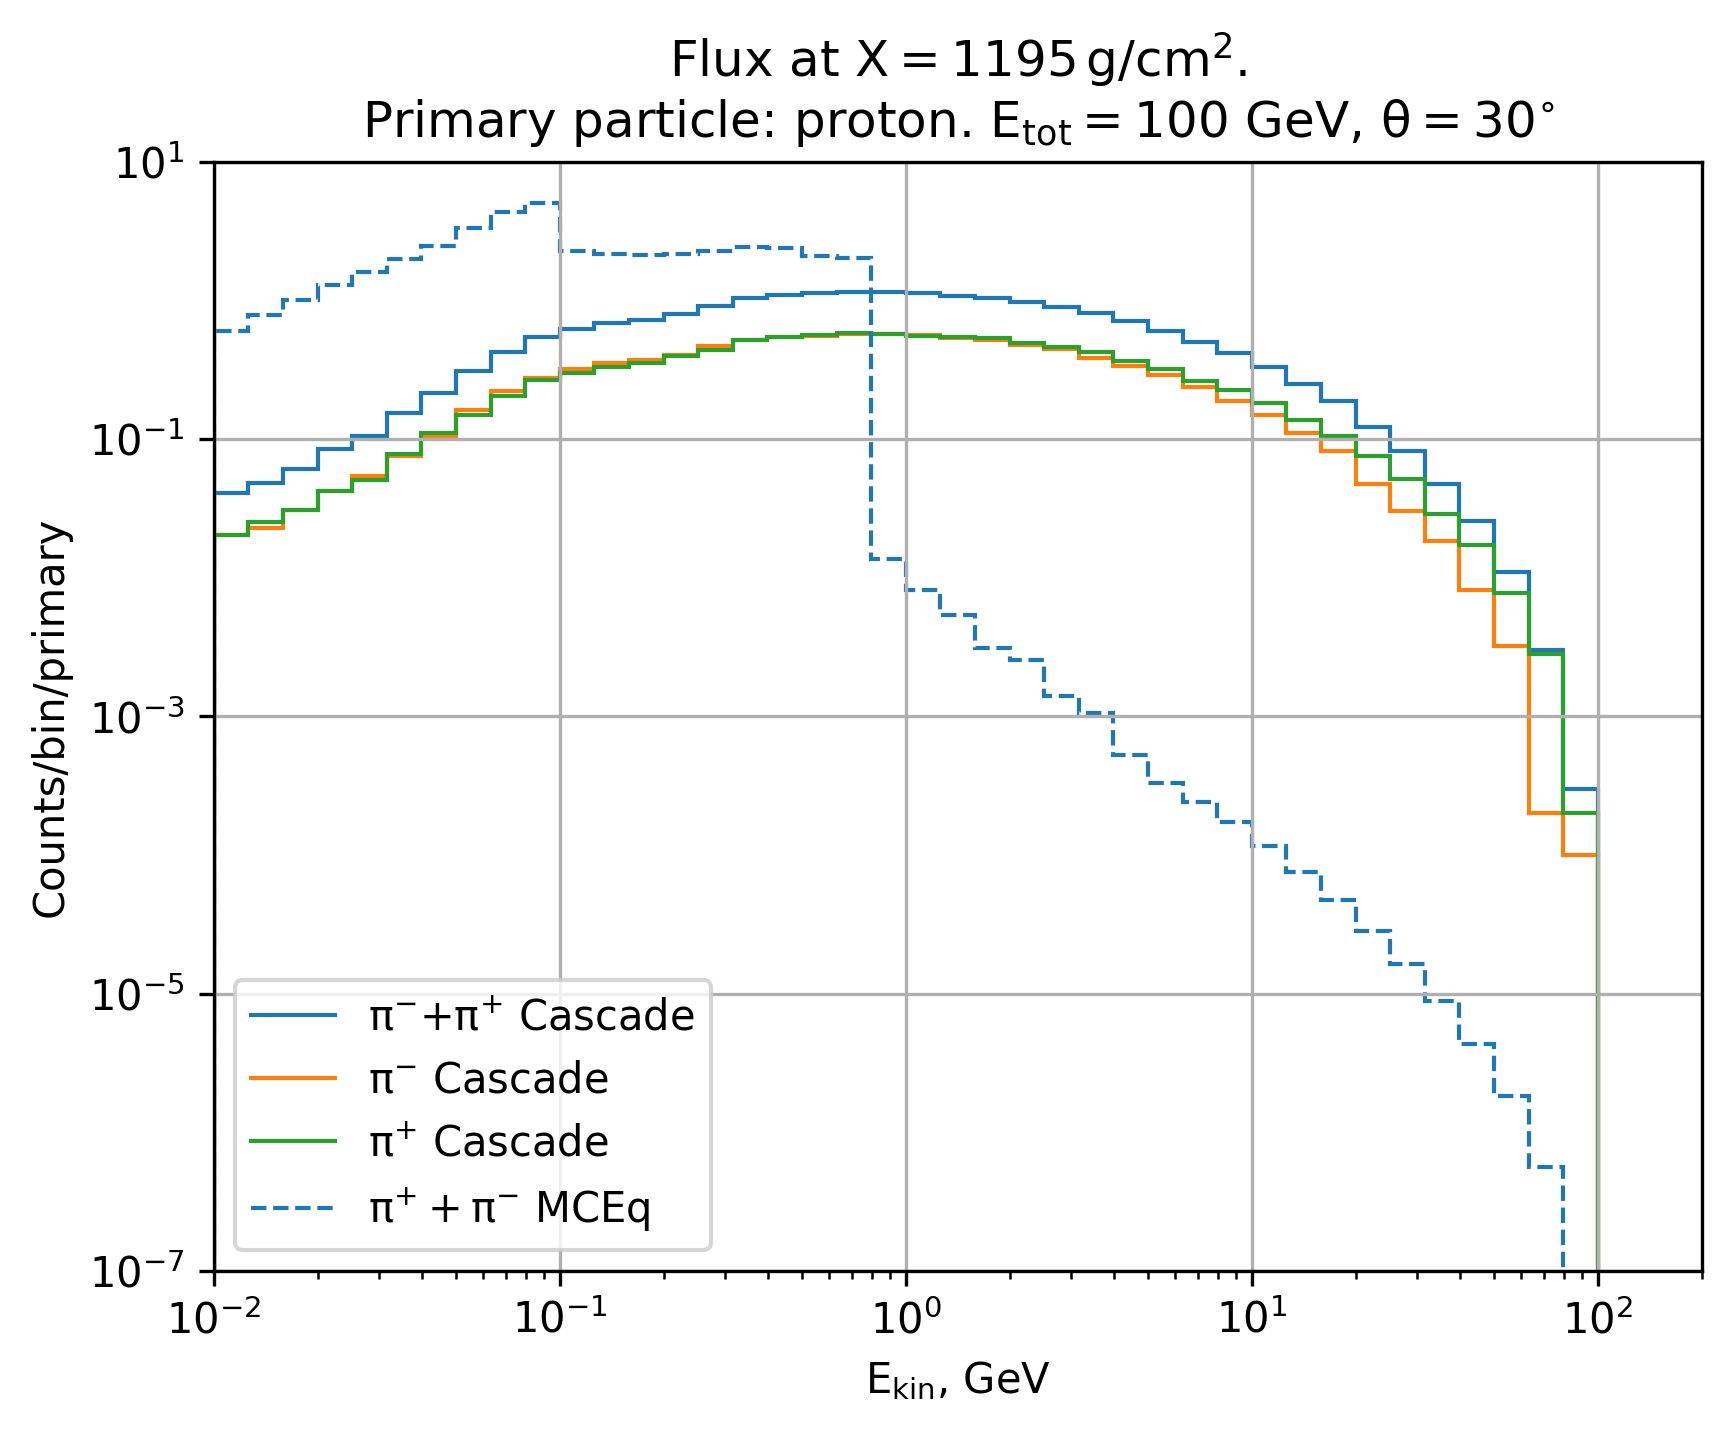

In [265]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211, 211), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[0])

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211,), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[1])

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (211,), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[2])


ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["pi"], mceq_dist.e_bins, 
           label = r"${\pi}^{+} + {\pi}^{-}$ MCEq", linestyle='--',
           color = line_colors[0])

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 2e2)
plt.ylim(1e-7, 10)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")
plt.savefig('04_nomuon_decay_piflux.svg')

Histogram of -13 with mass 0.10565837550000001
Histogram of 13 with mass 0.10565837550000001


Text(0, 0.5, 'Counts/bin/primary')

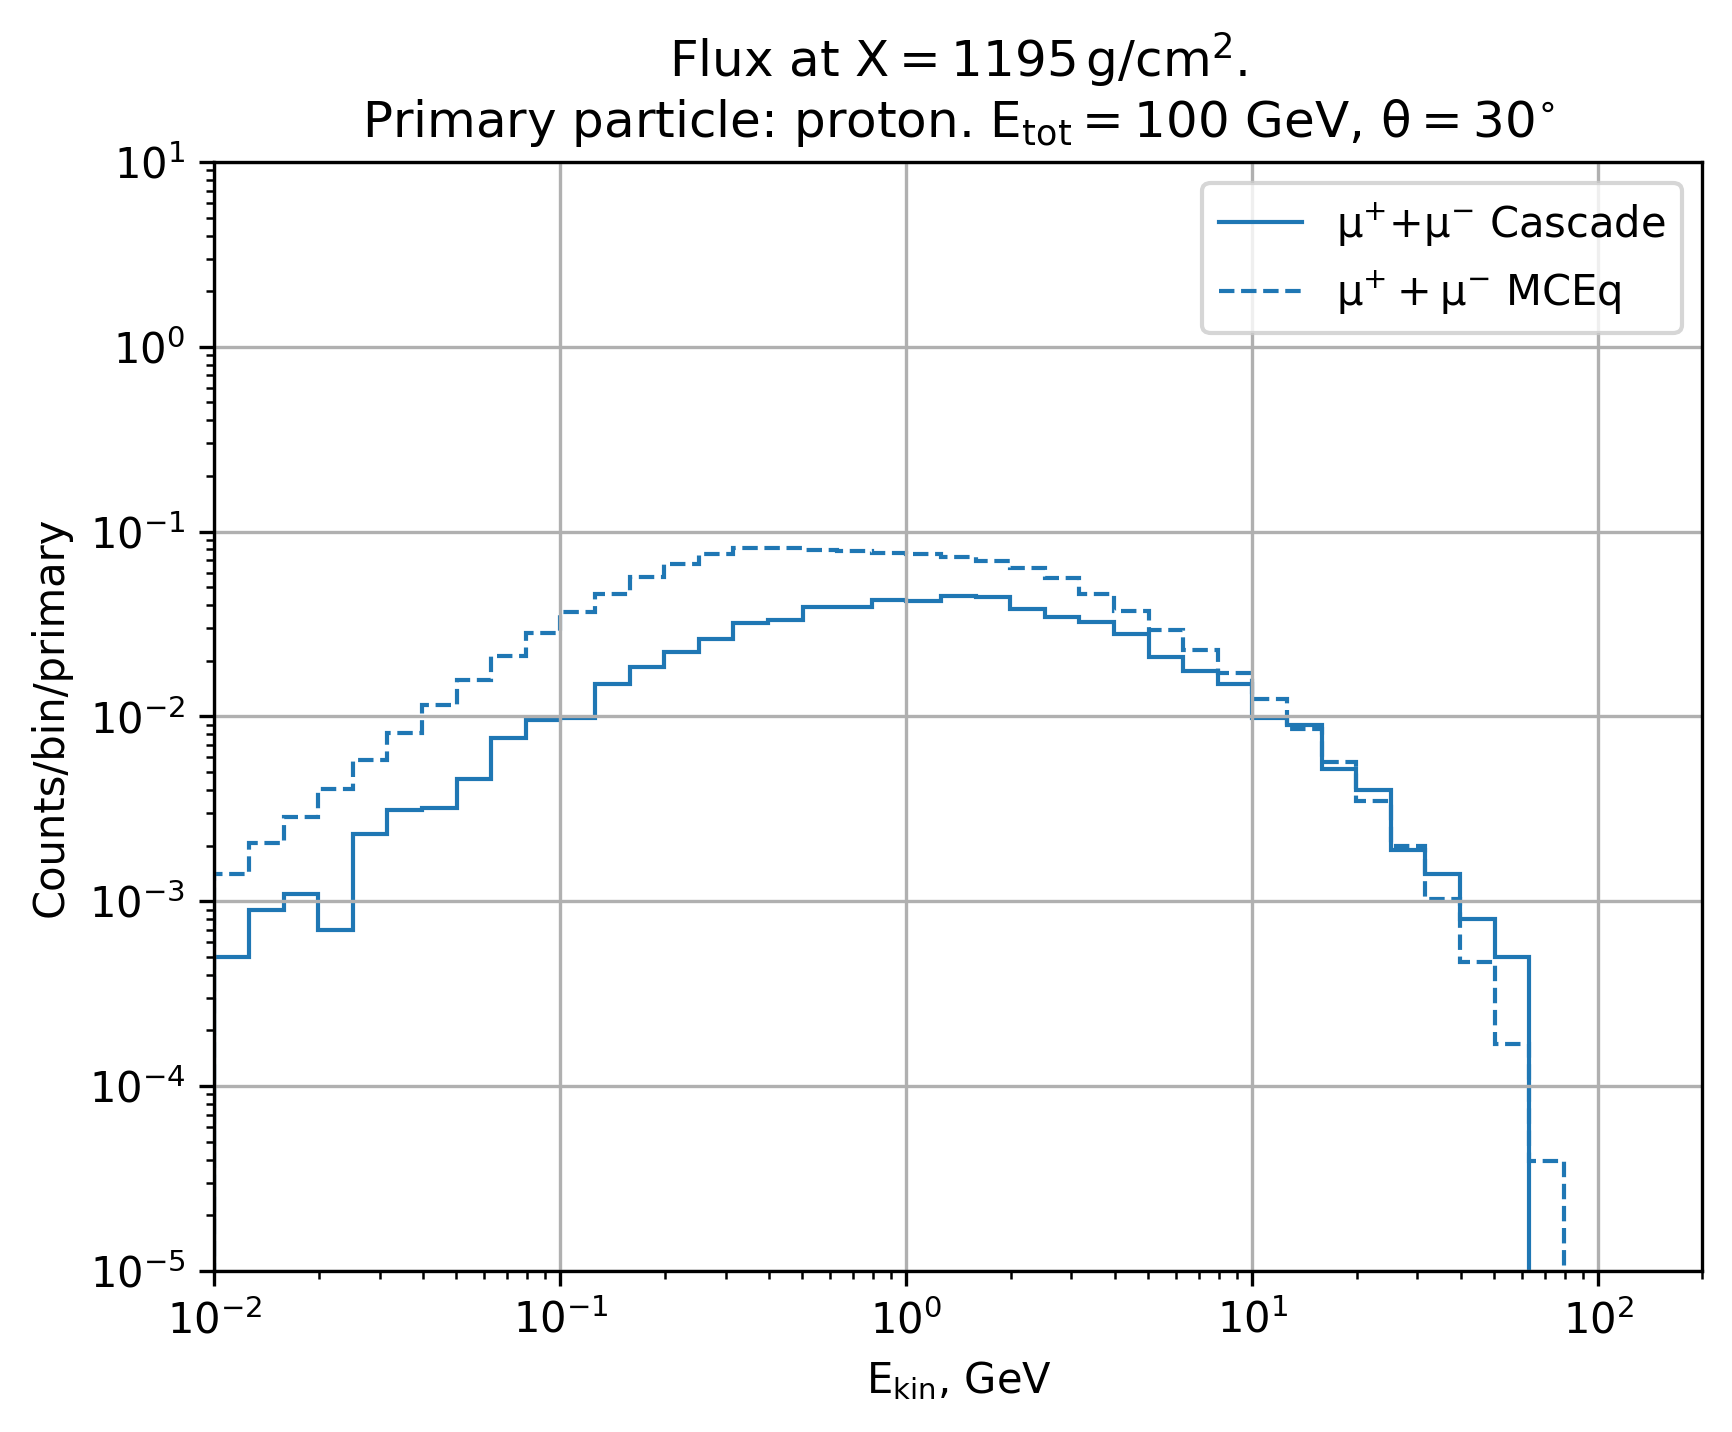

In [263]:
line_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-13, 13), bins = mceq_dist.e_bins)
plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[0])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-12, -12), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[1])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-14, 14), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = f"{label} Cascade", linestyle='-', color = line_colors[2])

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-211, 211), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11, 11), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (11,), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')

ixdepth = 3
plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ MCEq", linestyle='--',
           color = line_colors[0])


# plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

# plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
# plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
#            color = line_colors[2])
# plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
#            label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
#            color = line_colors[1])
# # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
#            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
#            label = r"${e}^{+}$ mceq", linestyle='--')

# plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
#            label = r"${e}^{-}$ mceq", linestyle='--')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-2, 2e2)
plt.ylim(1e-5, 10)
plt.legend()
plt.grid()
plt.title("Flux at " +  r"$X = 1195\, g/cm^2.$"+ "\nPrimary particle: proton. " 
          +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Counts/bin/primary")
# plt.savefig('01_nomuon_decay_flux.svg')

Histogram of -13 with mass 0.10565837550000001
Histogram of 13 with mass 0.10565837550000001
Histogram of -12 with mass 0.0
Histogram of 12 with mass 0.0
Histogram of -14 with mass 0.0
Histogram of 14 with mass 0.0


/tmp/ipykernel_2052987/1296374379.py:4: RuntimeWarning: invalid value encountered in divide
  plt.stairs(hist/mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins,
/tmp/ipykernel_2052987/1296374379.py:9: RuntimeWarning: invalid value encountered in divide
  plt.stairs(hist/mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins,
/tmp/ipykernel_2052987/1296374379.py:14: RuntimeWarning: invalid value encountered in divide
  plt.stairs(hist/mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins,


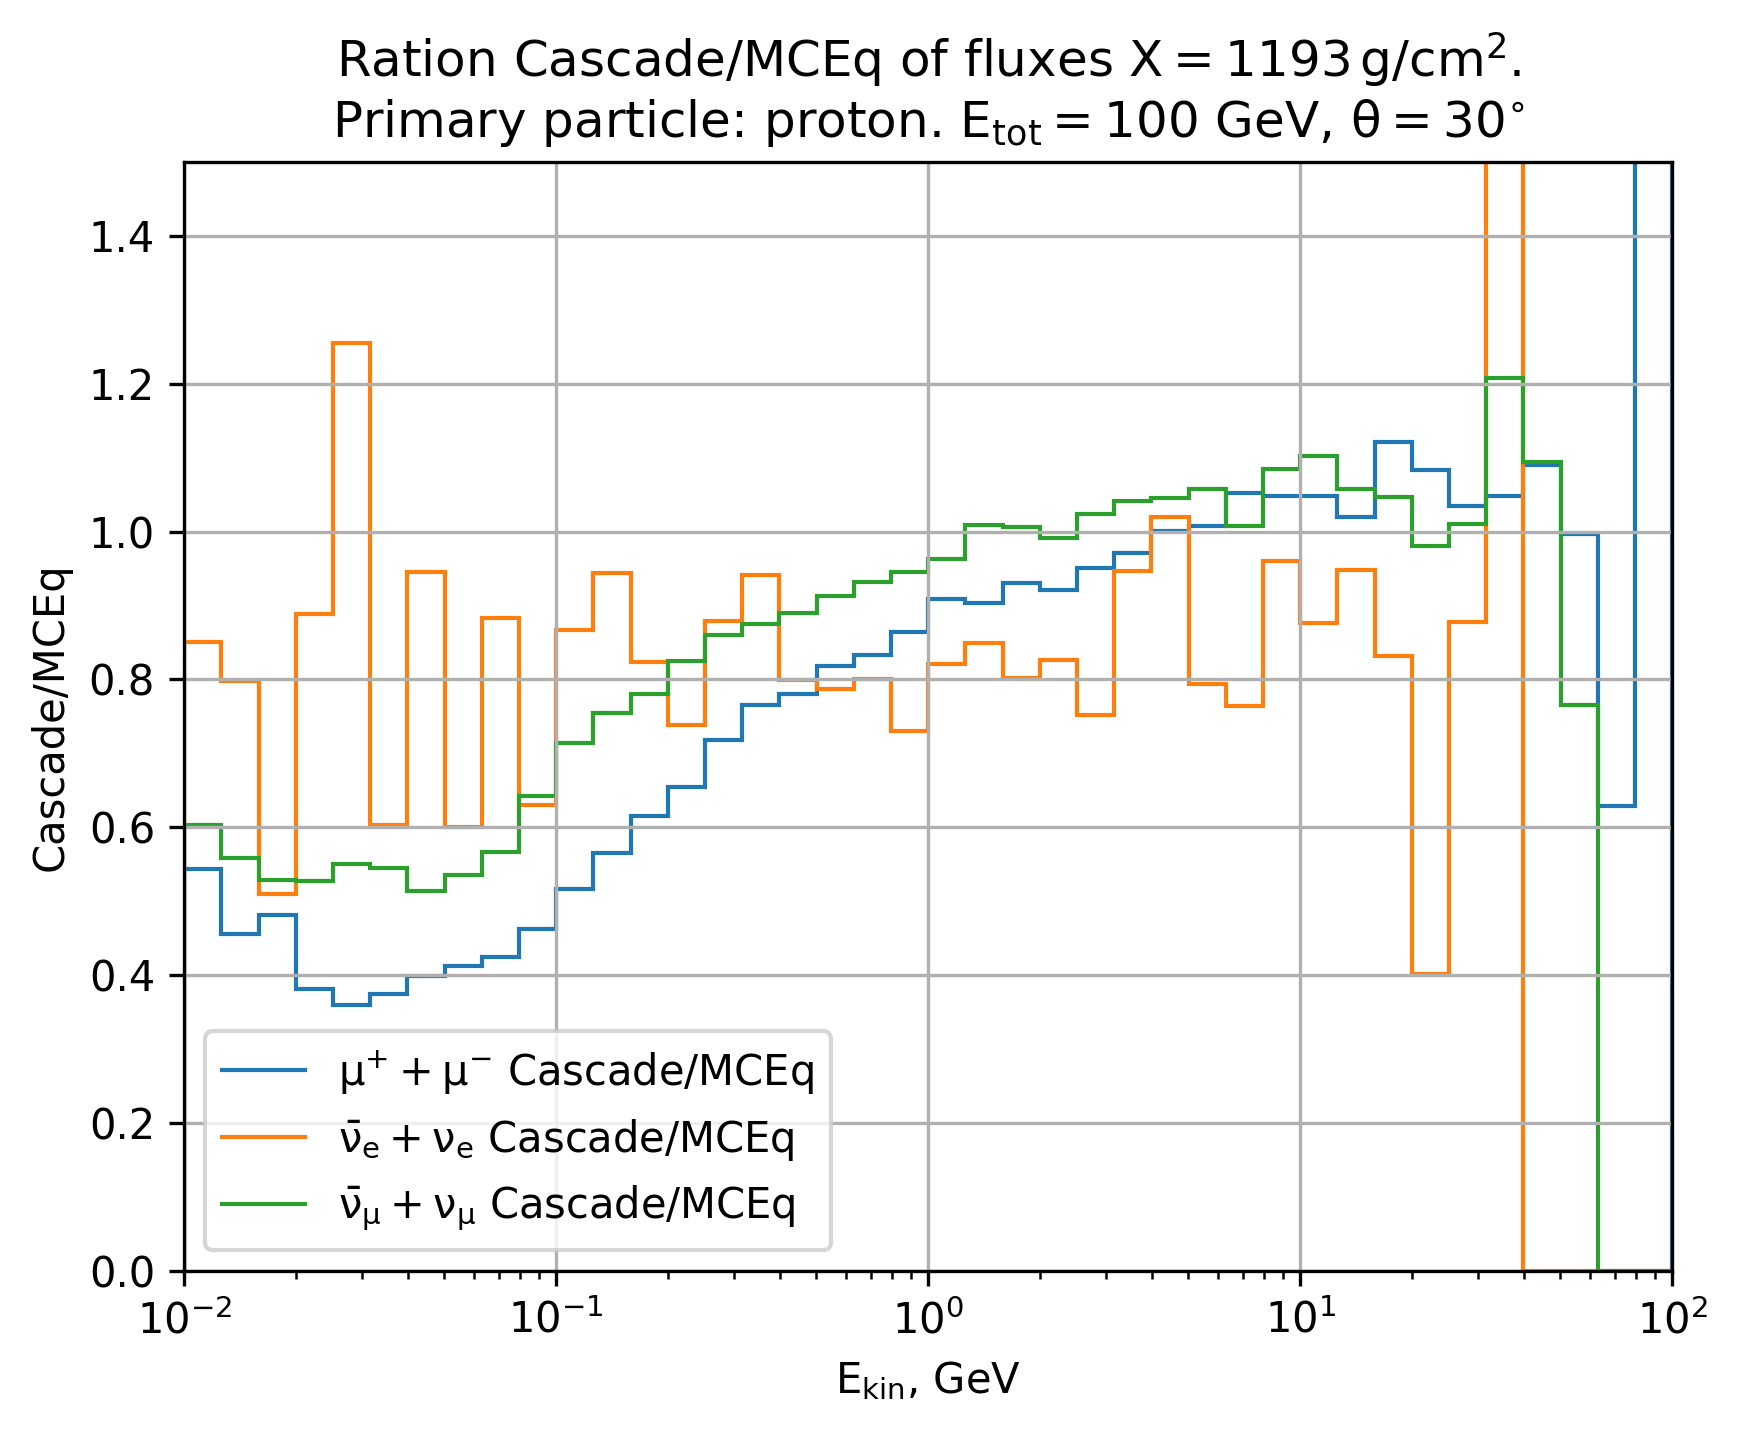

In [241]:
bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-13, 13), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')
ixdepth = 3
plt.stairs(hist/mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
           label = r"${\mu}^{+} + {\mu}^{-}$ Cascade/MCEq", linestyle='-')

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-12, 12), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')
plt.stairs(hist/mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
           label = r"$\bar{\nu}_{e} + {\nu}_{e}$ Cascade/MCEq", linestyle='-')

bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-14, 14), bins = mceq_dist.e_bins)
# plt.stairs(hist, bins, label = label, linestyle='-')
plt.stairs(hist/mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
           label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ Cascade/MCEq", linestyle='-')

# bins, hist, label = cascade_analysis.kin_energy_histogram(pdgs = (-11, 11), bins = mceq_dist.e_bins)
# # plt.stairs(hist, bins, label = label, linestyle='-')
# plt.stairs(hist/mceq_dist.flux["el"], mceq_dist.e_bins, 
#            label = r"${e}^{+} + {e}^{-}$ mceq no loss", linestyle='-')

# plt.stairs(mceq_loss.flux["mu"], mceq_loss.e_bins, 
#            label = r"${\mu}^{+} + {\mu}^{-}$ mceq loss", linestyle='--')

plt.xscale("log")
plt.xlim(1e-2, 1e2)
plt.ylim(0, 1.5)
plt.legend()
plt.grid()
plt.title("Ration Cascade/MCEq of fluxes " +  r"$X = 1193\, g/cm^2.$"+
          "\nPrimary particle: proton. " 
          +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
plt.xlabel(r"$E_{kin}$, GeV")
plt.ylabel(r"Cascade/MCEq")
plt.savefig('01_nomuon_decay_ratio.svg')

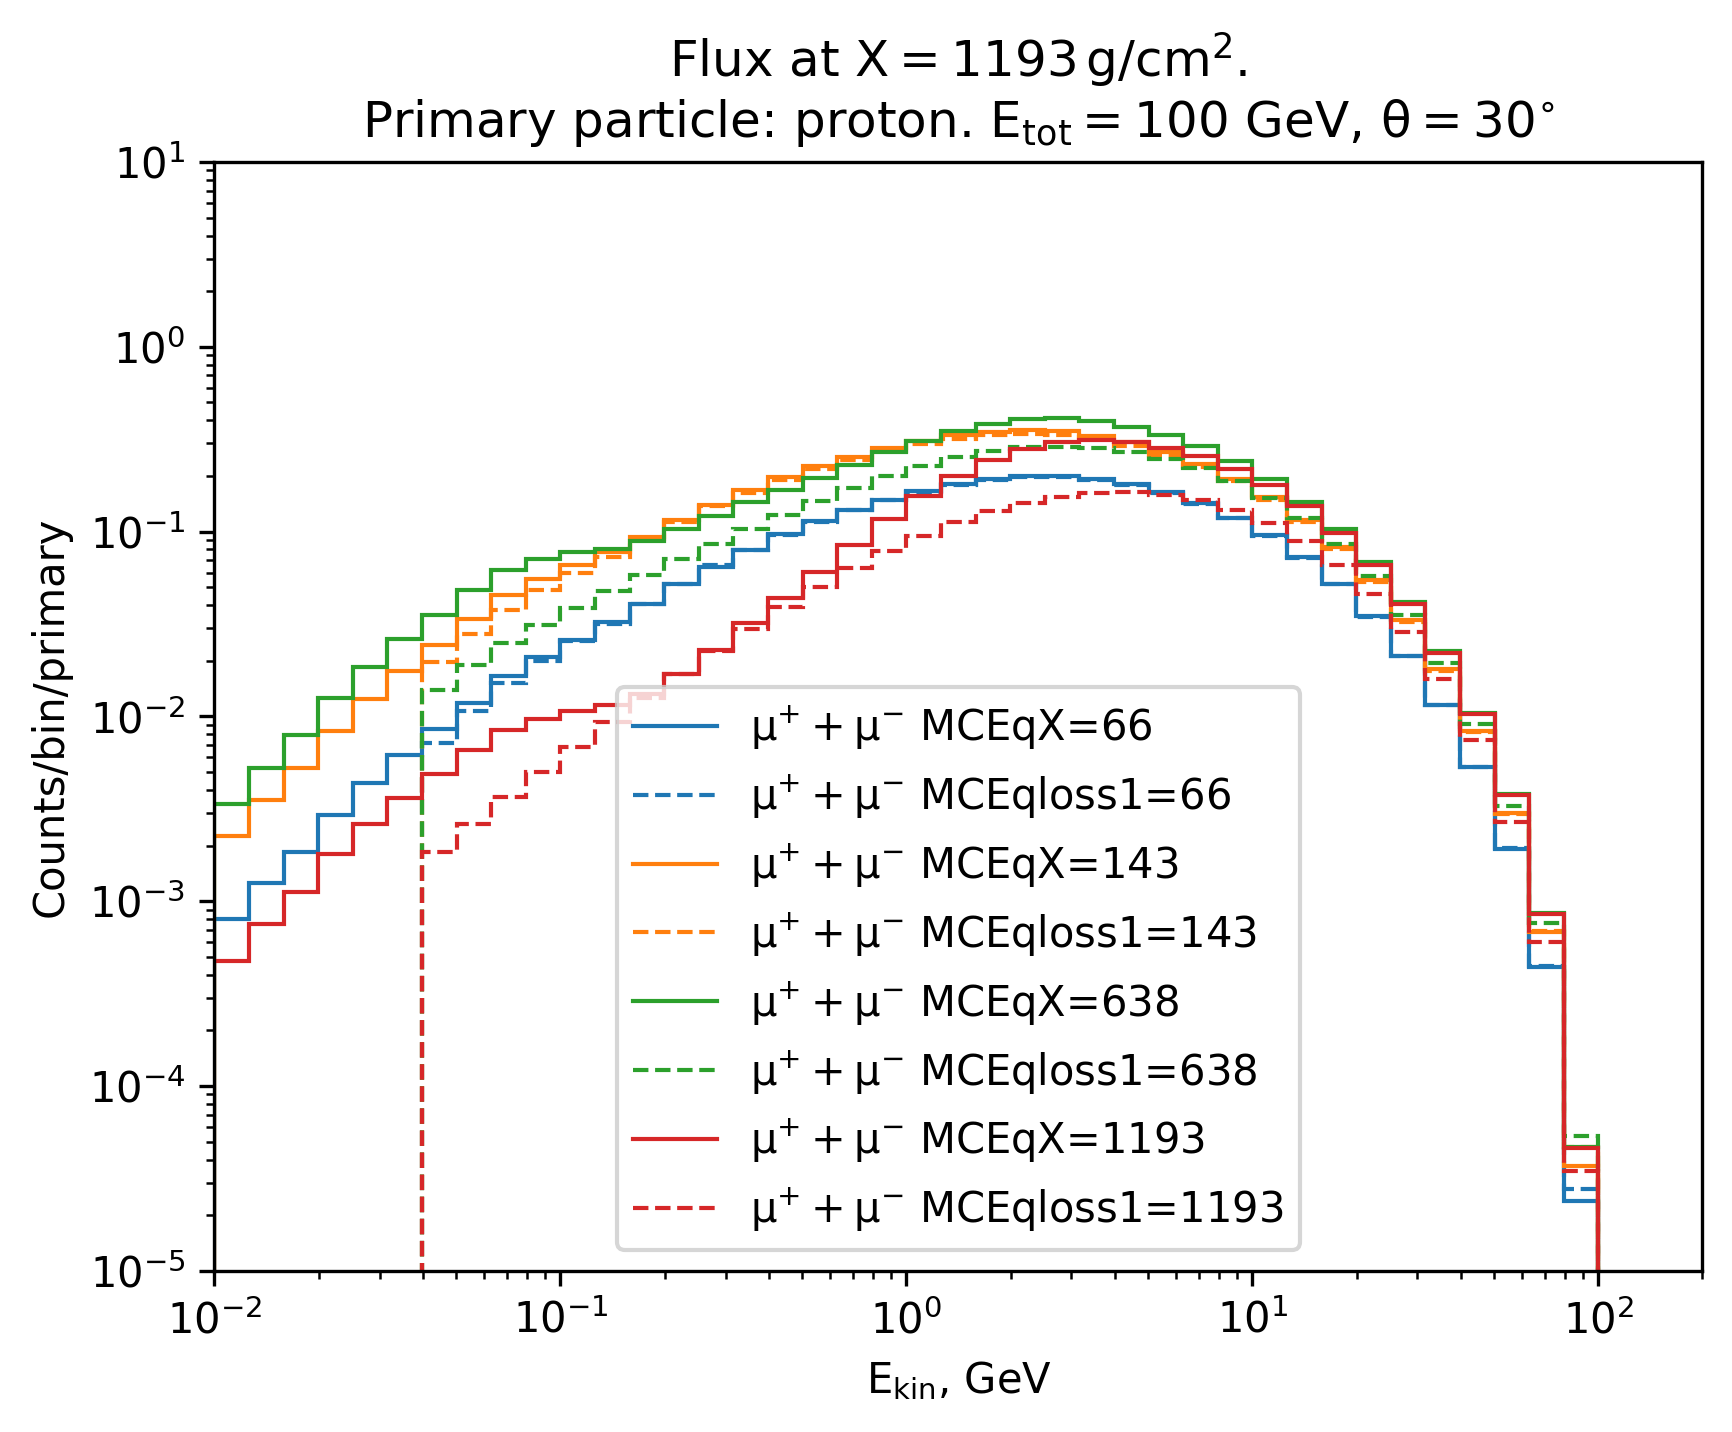

In [158]:
ixdepth = 0
xdepths_list = [0, 1, 2, 3]
# xdepths_list = [2, 3]

for ixdepth in xdepths_list:
    plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
            label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"X={mceq_dist.slant_depths[ixdepth]}", linestyle='-',
            color = line_colors[ixdepth])
    
#     plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
#             label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"X={mceq_loss.slant_depths[ixdepth]}", 
#             linestyle='--',
#             color = line_colors[ixdepth])
    
    plt.stairs(mceq_loss1.flux[ixdepth]["mu"], mceq_loss1.e_bins, 
            label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"loss1={mceq_loss1.slant_depths[ixdepth]}", 
            linestyle='--',
            color = line_colors[ixdepth])


    # plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

    # plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
    # plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
    #         color = line_colors[2])
    # plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
    #         color = line_colors[1])
    # # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
    #            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
    #            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
    #            label = r"${e}^{+}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
    #            label = r"${e}^{-}$ mceq", linestyle='--')

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-2, 2e2)
    plt.ylim(1e-5, 10)
    plt.legend()
    plt.grid()
    plt.title("Flux at " +  r"$X = 1193\, g/cm^2.$"+ "\nPrimary particle: proton. " 
            +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
    plt.xlabel(r"$E_{kin}$, GeV")
    plt.ylabel(r"Counts/bin/primary")
# plt.savefig('temp.png', transparent=True)

In [224]:
mceq_noloss = MCEQDistributions(
                 energy = 1e2,
                 pdg_id = 2212,
                 theta_deg = 30,
                 energy_range=[1e-2, 2e2],
                 slant_depths=[66, 143, 638, 1195],
                 pname_tuples = [
                     ("mu", "mu+", "mu-"),
                     ("numu", "numu", "antinumu"),
                     ("nue", "nue", "antinue"),
                     ("pi", "pi+", "pi-"),
                     ("el", "e+", "e-"),
                     ("e+", "e+"),
                     ("e-", "e-"),
                     ("pi_mu", "pi_mu+", "pi_mu-"),
                     ("k_mu",  "k_mu+", "k_mu-"),
                     ("K0_mu", "K0_mu+", "K0_mu-"),
                     ("prcas_mu", "prcas_mu+", "prcas_mu-"),
                     ("prres_mu", "prres_mu+", "prres_mu-"),
                     ],
                 interaction_model = "DPMJET-III-19.1",
                 generic_losses_all_charged = False, 
                 enable_energy_loss = False, 
                 muon_helicity_dependence = False,
                 disable_decays = [],
                 hybrid_crossover=0.01,
                 density_model = ("CORSIKA", ("USStd", None)))
                #  disable_decays = [-13, 13, -211, 211, 111]
mceq_dist = mceq_noloss

MCEqRun::set_interaction_model(): DPMJETIII191


ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('USStd', None)
MCEqRun::set_primary_model(): Primary model set to Hillas-Gaisser (H3a)


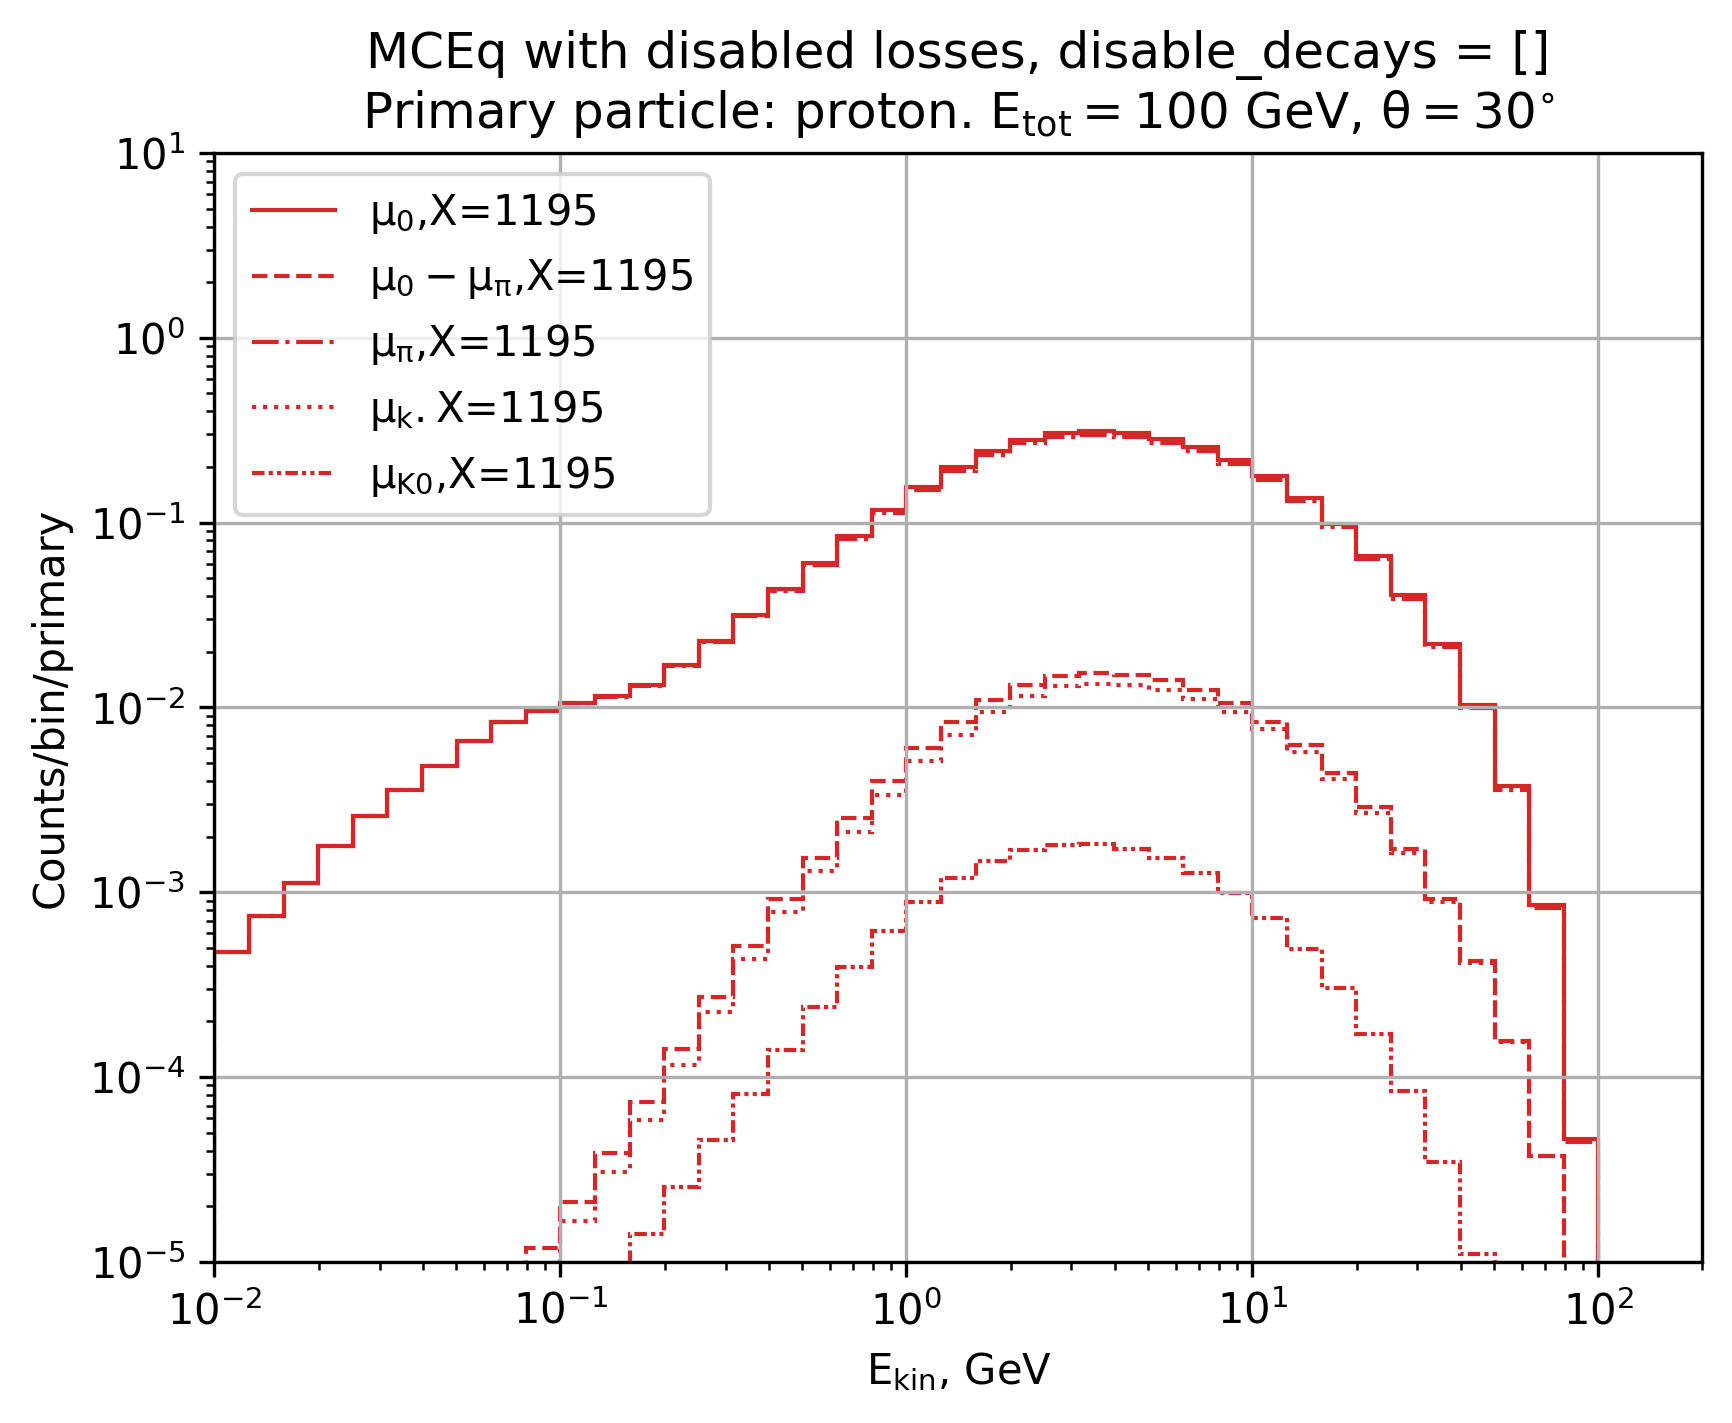

In [225]:
# xdepths_list = [0, 1, 2, 3]
xdepths_list = [3]

for ixdepth in xdepths_list:
    plt.stairs(mceq_dist.flux[ixdepth]["mu"], mceq_dist.e_bins, 
            label = r"$\mu_0$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle='-',
            color = line_colors[ixdepth])    
        
        
    plt.stairs(mceq_dist.flux[ixdepth]["mu"] - mceq_dist.flux[ixdepth]["pi_mu"], mceq_dist.e_bins, 
            label = r"$\mu_0 - \mu_{\pi}$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle='--',
            color = line_colors[ixdepth])
    
    plt.stairs(mceq_dist.flux[ixdepth]["pi_mu"], mceq_dist.e_bins, 
            label = r"$\mu_{\pi}$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle='-.',
            color = line_colors[ixdepth])
    
    plt.stairs(mceq_dist.flux[ixdepth]["k_mu"], mceq_dist.e_bins, 
            label = r"$\mu_{k}.$" 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle=':',
            color = line_colors[ixdepth])
    
    plt.stairs(mceq_dist.flux[ixdepth]["K0_mu"], mceq_dist.e_bins, 
            label = r"$\mu_{K0}$," 
            + f"X={mceq_dist.slant_depths[ixdepth]}", 
            linestyle=(0, (3, 1, 1, 1, 1, 1)),
            color = line_colors[ixdepth])
    
#     plt.stairs(mceq_loss.flux[ixdepth]["mu"], mceq_loss.e_bins, 
#             label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"X={mceq_loss.slant_depths[ixdepth]}", 
#             linestyle='--',
#             color = line_colors[ixdepth])
    
    # plt.stairs(mceq_loss1.flux[ixdepth]["mu"], mceq_loss1.e_bins, 
    #         label = r"${\mu}^{+} + {\mu}^{-}$ MCEq" + f"loss1={mceq_loss1.slant_depths[ixdepth]}", 
    #         linestyle='--',
    #         color = line_colors[ixdepth])


    # plt.stairs(mceq_loss.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ loss mceq", linestyle=':')

    # plt.stairs(mceq_hybrid.flux["mu"], mceq_dist.e_bins, 
    #            label = r"${\mu}^{+} + {\mu}^{-}$ mceq hb", linestyle='--')
    # plt.stairs(mceq_dist.flux[ixdepth]["numu"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{\mu} + {\nu}_{\mu}$ MCEq", linestyle='--',
    #         color = line_colors[2])
    # plt.stairs(mceq_dist.flux[ixdepth]["nue"], mceq_dist.e_bins, 
    #         label = r"$\bar{\nu}_{e} + {\nu}_{e}$ MCEq", linestyle='--',
    #         color = line_colors[1])
    # # plt.stairs(mceq_dist.flux["pi"], mceq_dist.e_bins, 
    #            label = r"$\bar{\pi}^{+} + {\pi}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["el"], mceq_dist.e_bins, 
    #            label = r"$\bar{e}^{+} + {e}^{-}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e+"], mceq_dist.e_bins, 
    #            label = r"${e}^{+}$ mceq", linestyle='--')

    # plt.stairs(mceq_dist.flux["e-"], mceq_dist.e_bins, 
    #            label = r"${e}^{-}$ mceq", linestyle='--')

    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(1e-2, 2e2)
    plt.ylim(1e-5, 10)
    plt.legend()
    plt.grid()
    plt.title("MCEq with disabled losses, disable_decays = []" + "\nPrimary particle: proton. " 
            +  r"$E_{tot}=100$ GeV" + r", $\theta = 30^{\circ}$")
    plt.xlabel(r"$E_{kin}$, GeV")
    plt.ylabel(r"Counts/bin/primary")
plt.savefig('16_MCEq_noloss.svg')